In [1]:
from lxml.html import parse
import urllib
from urllib.request import urlopen
from os.path import getsize
from math import log
from pandas import Series, DataFrame
import pandas as pd
import urllib 


In [7]:
##__________________利用一周高频数据，分别计算１分钟、１０分钟、１５分钟、半小时简单收益率和对数收益率______________________________
##下载高频数据时吃满内存电脑卡住，所以用老师提供的样例进行计算
data_high = pd.read_csv("data/600540.csv",encoding="gbk",index_col=0,parse_dates=True)
price_data = pd.DataFrame(data_high['price'])


In [8]:
##_______________________________________________1分钟简单收益率_______________________________________________________
price_of_1min = price_data.resample('T').mean()
ratio_1min = (price_of_1min/price_of_1min.shift(1)).dropna()
simple_1min= (price_of_1min/price_of_1min.shift(1) - 1 ).dropna()


In [9]:
##_______________________________________________10分钟简单收益率_______________________________________________________
price_of_10min = price_data.resample('10min').mean()
ratio_10min = (price_of_10min/price_of_10min.shift(1)).dropna()
simple_10min= (price_of_10min/price_of_10min.shift(1) - 1 ).dropna()

In [10]:
##_______________________________________________15分钟简单收益率_______________________________________________________
price_of_15min = price_data.resample('15min').mean()
ratio_15min = (price_of_15min/price_of_15min.shift(1)).dropna()
simple_15min= (price_of_15min/price_of_15min.shift(1) - 1 ).dropna()

In [11]:
##_______________________________________________30分钟简单收益率_______________________________________________________
price_of_30min = price_data.resample('30min').mean()
ratio_30min = (price_of_30min/price_of_30min.shift(1)).dropna()
simple_30min= (price_of_30min/price_of_30min.shift(1) - 1 ).dropna()

In [12]:
##_______________________________________________对数收益率____________________________________________________________
log_return_of_1min = ratio_1min['price'].map(log)
log_return_of_10min = ratio_10min['price'].map(log)
log_return_of_15min = ratio_15min['price'].map(log)
log_return_of_30min = ratio_30min['price'].map(log)

In [2]:
##___________利用最近三年复权日线数据，分别计算日收益率、周收益率、月收益率、季度收益率、年收益率简单收益率和对数收益率_________________


##____________________________________________get sina data__________________________________________________________
def get_sina_stock(stockid,start="1990-12-19",end=pd.datetime.now(),isstock=True,fuquan=True):    
    def _unpack(row, kind='td'):
        elts = row.findall('.//%s' % kind)
        return [val.text_content().strip() for val in elts] # .strip()去掉\r\t\n之类的字符    
    def parse_options_data(table,isstock,fuquan):
        rows = table.findall('.//tr')
        data = [_unpack(r) for r in rows[2:]]
        if isstock & fuquan:
            colnames = ['date','open','high','close','low','vol','amount','ratio'] # 回避中文处理
        else:
            colnames = ['date','open','high','close','low','vol','amount']
        data= pd.DataFrame(data,columns=colnames)
        data.index=pd.to_datetime(data["date"])
        data=data.drop("date",axis=1)
        data=data.ix[range(len(data)-1,-1,-1)]
        return  data
    data=pd.DataFrame()
    daterange=pd.date_range(start,end,freq="Q")
    daterange=daterange.insert(len(daterange),daterange[-1]+1)
    stockid=str(stockid).zfill(6)
    for cq in daterange: 
        if isstock:
            if fuquan:
                url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_FuQuanMarketHistory/stockid/'+str(stockid)+'.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)
            else:
                url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_MarketHistory/stockid/'+str(stockid)+'.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)            
        else:            
            url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_MarketHistory/stockid/'+str(stockid)+'/type/S.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)
        try:
            parsed = parse(url)
        except:
            print("download failed for year=" +str(cq.year)+',  jidu='+str(cq.month/3))
            continue
        doc = parsed.getroot()
        tables=doc.findall('.//table')     
        da= tables[-1] # last table 19 for fuquan data and 4 for index
        datatem = parse_options_data(da,isstock,fuquan)
        data=pd.concat([data,datatem])
    return pd.DataFrame(data[start:end],dtype=float)    



In [14]:
##____________________________________import stock data : stock id 600325_____________________________________________
stockprice0 = get_sina_stock(600325,"2013-10-26","2016-10-26")
stockprice = stockprice0['close']
ratio_daily = (stockprice/stockprice.shift(1)).dropna()

stockprice_weekly = stockprice.resample('W-FRI').mean()
ratio_weekly = (stockprice_weekly/stockprice_weekly.shift(1)).dropna()

stockprice_monthly = stockprice.resample('M').mean()
ratio_monthly = (stockprice_monthly/stockprice_monthly.shift(1)).dropna()

stockprice_quarterly = stockprice.resample('Q').mean()
ratio_quarterly = (stockprice_quarterly/stockprice_quarterly.shift(1)).dropna()

stockprice_yearly = stockprice.resample('A').mean()
ratio_yearly = (stockprice_yearly/stockprice_yearly.shift(1)).dropna()

In [15]:
##__________________________________________simple return____________________________________________________________
simple_return_daily = ratio_daily-1
simple_return_weekly = ratio_weekly-1
simple_return_monthly = ratio_monthly-1
simple_return_quarterly = ratio_quarterly -1
simple_return_yearly = ratio_yearly -1


In [16]:
##__________________________________________log return____________________________________________________________
log_return_daily = ratio_daily.map(log)
log_return_weekly = ratio_weekly.map(log)
log_return_monthly = ratio_monthly.map(log)
log_return_quarterly = ratio_quarterly.map(log)
log_return_yearly = ratio_yearly.map(log)



In [17]:
##____________________________________________transfer_____________________________________________________________
def trans5_2_10(return_of_5mins):
    return_of_10mins = (return_of_5mins * return_of_5mins.shift(1)).applymap(log)
    return return_of_10mins

##转换关系：10分钟对数收益率 = log(前5分钟简单收益率* 后5分钟简单收益率）

price_of_5min = price_data.resample('5min').mean()
ratio_5min = pd.DataFrame((price_of_5min/price_of_5min.shift(1)).dropna())
trans5_2_10(ratio_5min)

,price
time,
2016-10-29 09:30:00,NaN
2016-10-29 09:35:00,-0.002011
2016-10-29 09:40:00,-0.001152
2016-10-29 09:45:00,0.001252
2016-10-29 09:50:00,0.002419
2016-10-29 09:55:00,0.002124
2016-10-29 10:00:00,0.002931
2016-10-29 10:05:00,0.001119
2016-10-29 10:10:00,-0.000674


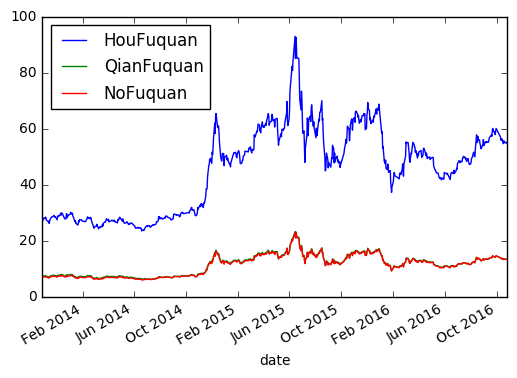

In [18]:
%matplotlib inline 
data_nonrecovered=get_sina_stock(600325,"2013-10-26","2016-10-26",fuquan=False)

data_recovered=get_sina_stock(600325,"2013-10-26","2016-10-26")

data_recovered2=data_recovered['ratio']*data_nonrecovered['close']

max_ratio = data_recovered['ratio'].max()

data_frontrecovered = data_nonrecovered['close']*max_ratio/data_recovered['ratio']

data_All=pd.concat([data_recovered2,data_frontrecovered,data_nonrecovered['close']],axis=1)

data_All.columns=["HouFuquan","QianFuquan","NoFuquan"]

data_All.plot()


